In [4]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import re
import itertools
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Данные для запроса
access_token = "vk1.a.nuXxpclU0Gc3koMcFE1cnRztIKJD7nUvR-B5JboHTwV_XdoOIm99795ubTdhwsO29bqiKG6DtrjiWH3sc4FgEBNtn8XeBHUprMLmwKyONAjbEvM3OeXxhgB-GE9SkffucUekrj7iy5wSrSPWgo1ZN3d-1n1_Xmiw05IqvSTxVBP4sifkPHz5PTTNfsiHop1iTcW8auAXkKOZvsSiSrsSIg"
url_start = "https://vk.com/kinocube_official"
url = url_start.split('/')
domain = url[-1]

# Получаем id группы через запрос
def get_group_id(access_token, domain):
    response = requests.get('https://api.vk.com/method/utils.resolveScreenName',
                            params={'access_token': access_token,
                                    'screen_name': domain,
                                    'v': 5.199})
    response_json = response.json()
    if 'response' in response_json and 'object_id' in response_json['response']:
        return response_json['response']['object_id']
    else:
        raise ValueError("Не удалось получить ID группы. Проверьте корректность access_token и domain.")

# Получаем ID группы
id_group = get_group_id(access_token, domain)

# Функция для получения данных по запросу
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

# Пример использования функции getjson
def fetch_vk_data(access_token, id_group):
    version = '5.199'
    url = f"https://api.vk.com/method/wall.get?access_token={access_token}&owner_id=-{id_group}&count=100&v={version}"
    data = getjson(url)
    return data

# Пример вызова
try:
    vk_data = fetch_vk_data(access_token, id_group)
    print(vk_data)
except Exception as e:
    print(f"Произошла ошибка: {e}")

{'response': {'count': 324, 'items': [{'inner_type': 'wall_wallpost', 'ads_easy_promote': {'type': 0, 'text': ' В записи не должно быть эмодзи.', 'label_text': '', 'button_text': '', 'is_ad_not_easy': False}, 'can_edit': 1, 'created_by': 281511688, 'can_delete': 1, 'can_pin': 1, 'donut': {'is_donut': False}, 'is_pinned': 1, 'comments': {'can_post': 1, 'can_close': 1, 'can_view': 1, 'count': 1, 'groups_can_post': True}, 'marked_as_ads': 0, 'hash': 'clQ_57qSp-fVwwW8oJqdgxuF7w4y', 'postponed_id': 983, 'type': 'post', 'carousel_offset': 0, 'attachments': [{'type': 'photo', 'photo': {'album_id': -7, 'date': 1729096638, 'id': 457241465, 'owner_id': -215971748, 'access_key': '07d00b82b9e3e1e6e0', 'sizes': [{'height': 75, 'type': 's', 'width': 75, 'url': 'https://sun6-20.userapi.com/s/v1/ig2/3j5SVEx02zDjxDGBB0HoXRoHOGomm3Clak1wMmmGVbNmRftxoIz77F-I3tj6Ei9L2MA9g-FnrbcIpGHAgLNCqvz6.jpg?quality=95&as=32x32,48x48,72x72,108x108,160x160,240x240,360x360,480x480,540x540,640x640,720x720,1080x1080,1280x1

In [ ]:
# Создание переменной для "сдвига" получаемых данных
offset = 0
# Количество строк данных для одного запроса
count = 1
# Список ответов сервера
responses = []
days = 0
while days  < 365:
    url = 'https://api.vk.com/method/wall.get?access_token='+ access_token + '&offset='+ str(offset) + '&count=' + str(count) + '&v=' + '5.199' + '&domain=' + 'kinocube_official'
    response = getjson(url)
    responses.append(response)
    days = (datetime.now() - datetime.fromtimestamp(response['response']['items'][0]['date'])).days
    offset+=1

In [5]:
# Создаем списки содержащие в себе определенный набор данных

likes = []
views = []
comments = []
date = []
text = []
reposts = []
hash_tags = []
post_id = []
votes = []
attachments = []

expr = r'#\w+'

for j in range(len(responses)):
    for i in range(count):
        # Общую часть запроса к json словарю определим переменной
        main_dict = responses[j]['response']['items'][i]
        # Список id постов
        post_id.append(main_dict['id'])
        # Список количества репостов
        reposts.append(main_dict['reposts']['count'])
        # Список текстов постов
        text.append(len(main_dict['text']))
        # Список количества лайков
        likes.append(main_dict['likes']['count'])
        # Список количества просмотров постов
        views.append(main_dict['views']['count'])
        # Список количества комментариев
        comments.append(main_dict['comments']['count'])
        # Находим хэштеги
        tags = re.findall(expr, main_dict['text'])
        # Список преобразованных хэштегов
        hash_tags.append(list(map(lambda x: x[1:].lower().replace('_', ' ').replace('skillbox', '').strip(),tags)))
        # Список преобразованных дат
        date.append((datetime.fromtimestamp(main_dict['date']) - timedelta(hours=0)))
        # Список типов медиавложений в посте
        attachments.append(list(set([list(x.keys())[1] for x in main_dict['attachments']])))
        # Список голосов в постах с прикрепленным голосованием
        try:
            votes.append(main_dict['attachments'][1]['poll']['votes'])
        except:
            votes.append(None)

# Создаем пустой датафрейм
data = pd.DataFrame()

# Наполняем датафрейм полученными списками
data['id'] = post_id
data['likes'] = likes
data['views'] = views
data['reposts'] = reposts
data['comments'] = comments
data['date'] = date
data['text'] = text
data['tags'] = hash_tags
data['votes'] = votes
data['attachments'] = attachments

data

,id,likes,views,reposts,comments,date,text,tags,votes,attachments
0,984,16,626,11,1,2024-10-15 23:30:00,903,[анонс],None,"[link, photo]"
1,993,9,238,1,0,2024-10-19 22:00:00,340,"[авторское, периоды в истории кино]",None,[link]
2,991,9,276,1,0,2024-10-18 23:30:00,2553,[авторское],None,[photo]
3,990,5,268,0,0,2024-10-18 18:00:26,269,[авторское],None,[video]
4,989,16,335,1,0,2024-10-17 22:45:00,4882,[авторское],None,[photo]
...,...,...,...,...,...,...,...,...,...,...
139,654,26,508,0,0,2024-02-29 20:00:10,386,[авторское],None,[video]
140,653,29,712,2,0,2024-02-29 19:00:02,5068,"[авторское, o личности]",None,[photo]
141,651,31,672,1,0,2024-02-28 23:00:05,335,[анонс],None,[video]
142,649,28,754,9,0,2024-02-27 21:00:02,6001,[авторское],None,[photo]


In [21]:
data

,id,likes,views,reposts,comments,date,text,tags,votes,attachments,rubr
0,984,16,626,11,1,2024-10-15 23:30:00,903,[анонс],None,"[link, photo]",Анонс
1,993,9,238,1,0,2024-10-19 22:00:00,340,"[авторское, периоды в истории кино]",None,[link],Статья
2,991,9,276,1,0,2024-10-18 23:30:00,2553,[авторское],None,[photo],Статья
3,990,5,268,0,0,2024-10-18 18:00:26,269,[авторское],None,[video],Статья
4,989,16,335,1,0,2024-10-17 22:45:00,4882,[авторское],None,[photo],Статья
...,...,...,...,...,...,...,...,...,...,...,...
139,654,26,508,0,0,2024-02-29 20:00:10,386,[авторское],None,[video],Статья
140,653,29,712,2,0,2024-02-29 19:00:02,5068,"[авторское, o личности]",None,[photo],Статья
141,651,31,672,1,0,2024-02-28 23:00:05,335,[анонс],None,[video],Анонс
142,649,28,754,9,0,2024-02-27 21:00:02,6001,[авторское],None,[photo],Статья


In [22]:
row = data.loc[data['id'] == 990]
print(row)


    id  likes  views  reposts  comments                date  text  \
3  990      5    268        0         0 2024-10-18 18:00:26   269   

          tags votes attachments    rubr  
3  [авторское]  None     [video]  Статья  


In [7]:
data.dtypes

id                      int64
likes                   int64
views                   int64
reposts                 int64
comments                int64
date           datetime64[ns]
text                    int64
tags                   object
votes                  object
attachments            object
dtype: object

In [18]:
# Выгружаем данные в файл CSV
data.to_csv('vk_data.csv', index=False, encoding='utf-8-sig')

In [19]:
# Посмотрим какие существуют хэштеги в нашем паблике

new_list=set()
for i in data.tags:
    for j in i:
        new_list.add(j)

new_list

{'o личности',
 'авторское',
 'анонс',
 'деньрождения',
 'драйв',
 'дюна2',
 'идеальныедни',
 'кинофестиваль',
 'кинфестиваль',
 'мюзиклыотмарфы',
 'новости',
 'о личности',
 'оличности',
 'отчаянныедомохозяйки',
 'отчёт',
 'периоды в истории кино',
 'разведка',
 'твинпикс',
 'технокино',
 'чарли и шоколадная фабрика'}

In [33]:
# Функция для подсчета количества встречающихся хэштегов

def counter(x, array):
    value = 0
    for item_list in array:
        if x in item_list:
            value += 1
    return value

In [37]:
# Датафрейм со значением хэштэга и его количеством

counts_df = pd.DataFrame()

new_list = list(new_list)

counts = list(map(lambda x: counter(x, list(data.tags)), new_list))
counts_df['value'] = new_list
counts_df['count'] = counts
counts_df.sort_values('count', ascending=False).head(25)

,value,count
13,авторское,101
8,кинофестиваль,26
14,анонс,8
12,технокино,3
7,твинпикс,2
0,оличности,2
1,новости,2
2,деньрождения,1
3,дюна2,1
6,о личности,1


In [38]:
# Распределяем хэштеги по подходяшим рубрикам

dict_of_rubr = {
    'Статья':['статья', 'авторское'],
    'Вам слово':['вам слово'],
    'Отчет':['отчёт', 'podcast', 'подкасты'],
    'Анонс':['анонс',],
    'Новости':['новости',],
    'Фестиваль':['кинофестиваль', 'технокино'],
    'Оличности':['оличности', 'о личности'],
    'Видео': []
}

In [39]:
# Преобразуем словарь с рубриками к удобному для работы виду
lists_of_rubr = [[(i, j) for j in dict_of_rubr[i]] for i in dict_of_rubr]
flatten_genres = list(itertools.chain(*lists_of_rubr))

rubr_df = pd.DataFrame(flatten_genres, columns=['genre', 'word'])

In [40]:
# Объединенная функция для подбора рубрики для постов по хэштегам и вложениям
def assign_rubr(row, df):
    # Проверяем наличие видео во вложениях
    if 'video' in row['attachments']:
        return 'Видео'
    
    # Если видео нет, ищем соответствие рубрике по хэштегам
    for tag in row['tags']:
        if tag in list(df.word):
            return df.set_index('word').loc[tag, :].values[0]
    
    # Если не найдено соответствие ни по вложениям, ни по хэштегам
    return 'Без рубрики'

In [41]:
# Применение функции assign_rubr к каждому ряду датафрейма
data['rubr'] = data.apply(lambda row: assign_rubr(row, rubr_df), axis=1)
# Создаем новый датафрейм со средними значениями данных по метрикам активности пользователей для каждой рубрики
data_avg = data[['rubr', 'likes', 'views', 'reposts', 'comments', 'votes']].groupby('rubr').agg('mean')

data_avg



,likes,views,reposts,comments,votes
rubr,,,,,
Анонс,30.666667,2336.000000,20.000000,1.500000,NaN
Без рубрики,19.545455,861.181818,3.454545,1.090909,NaN
Видео,17.711538,577.961538,0.942308,0.173077,NaN
Новости,34.500000,814.500000,2.500000,1.500000,NaN
Оличности,17.000000,676.000000,2.000000,2.000000,NaN
Отчет,25.000000,451.000000,0.000000,1.000000,NaN
Статья,21.285714,661.803571,1.821429,0.767857,NaN
Фестиваль,20.133333,602.866667,1.800000,0.133333,NaN


In [42]:
# Фильтруем строки с рубрикой "Без рубрики"
no_category_data = data[data['rubr'] == 'Без рубрики']

# Выводим ID постов, попавших в рубрику "Без рубрики"
no_category_ids = no_category_data['id']

print(no_category_ids)


11     967
40     912
53     877
55     871
60     861
67     845
80     811
84     804
91     789
107    759
108    747
Name: id, dtype: int64


In [43]:
# Удельные показатели активности пользователей. Каждая метрика в завсисмости от количества просмотров в процентах

data_spec = data_avg[['likes','comments','reposts']].div(data_avg['views'], axis=0)*1000
data_spec

,likes,comments,reposts
rubr,,,
Анонс,13.127854,0.642123,8.561644
Без рубрики,22.696084,1.266758,4.011401
Видео,30.644839,0.299461,1.630399
Новости,42.357274,1.841621,3.069368
Оличности,25.147929,2.958580,2.958580
Отчет,55.432373,2.217295,0.000000
Статья,32.163190,1.160249,2.752219
Фестиваль,33.395997,0.221166,2.985735


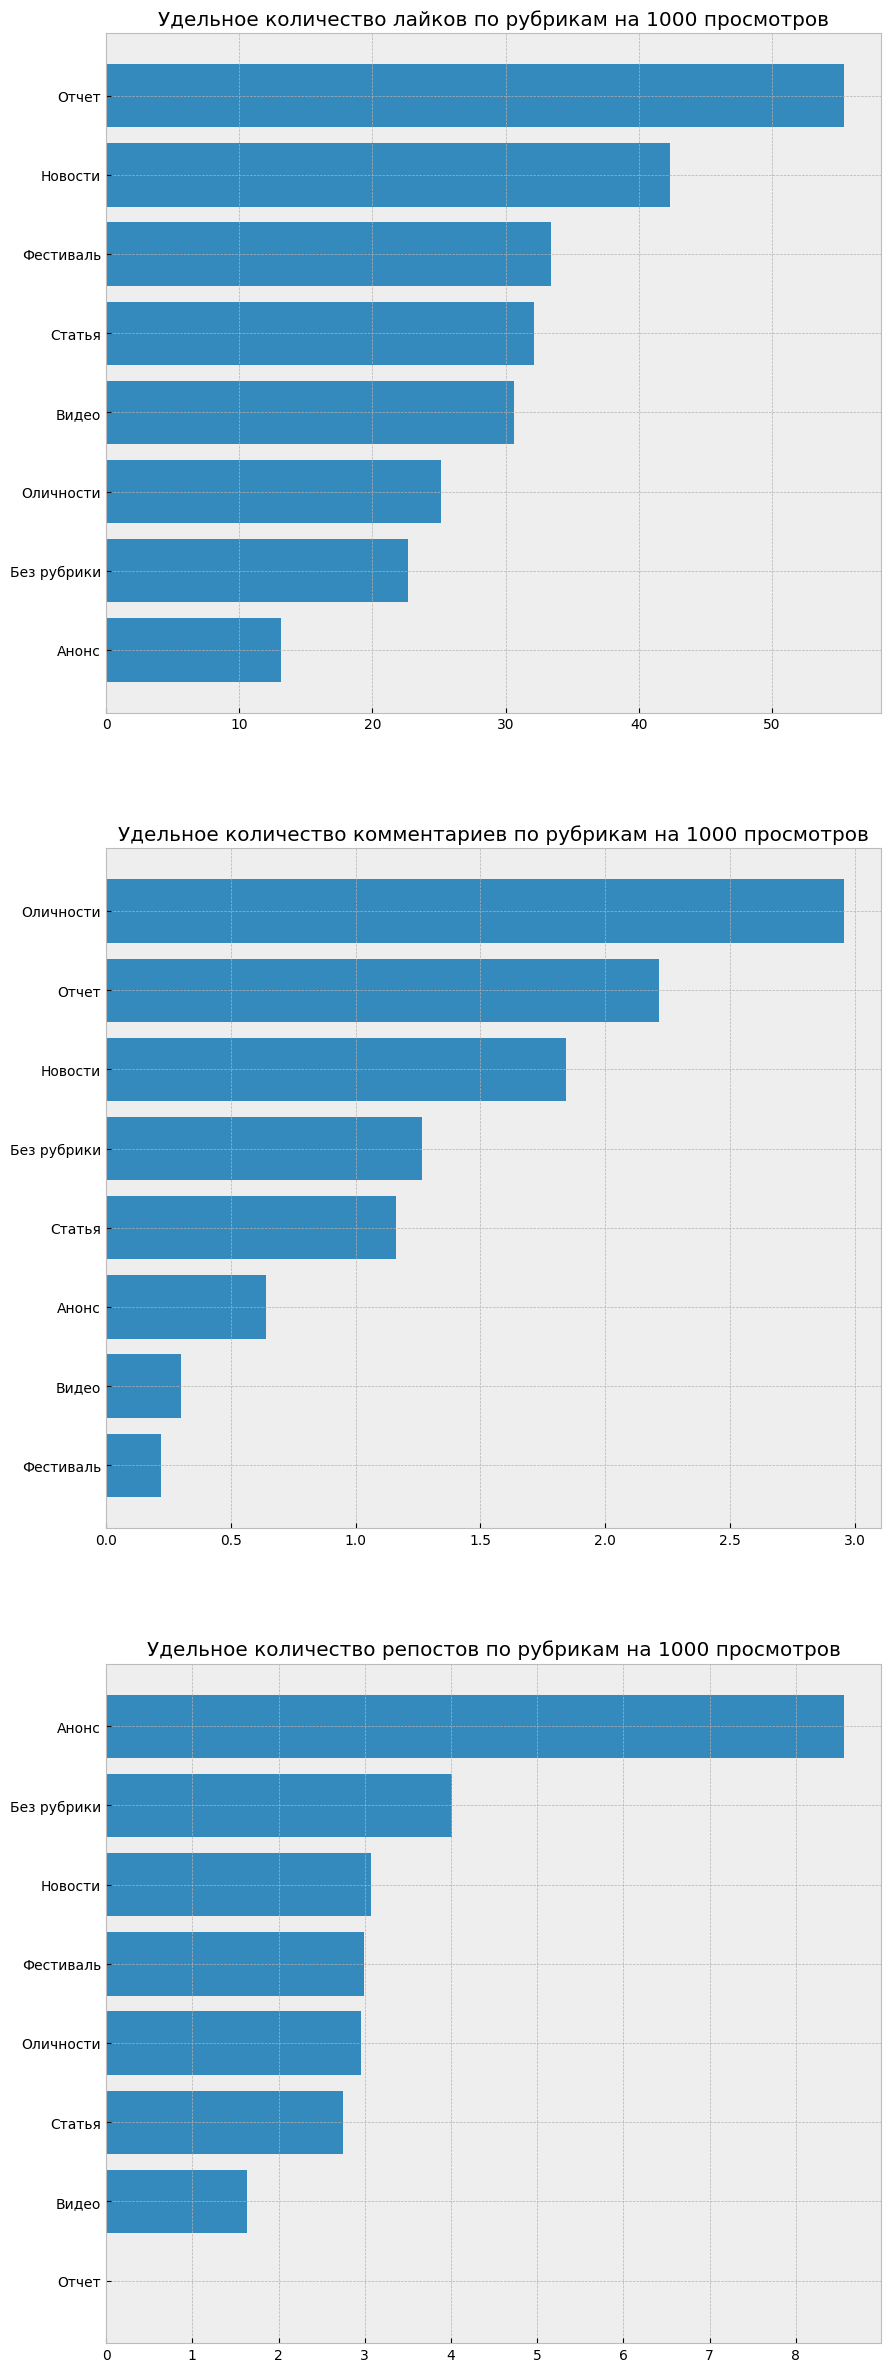

In [44]:
# Построим графики удельного количества лайков, комментариев и репостов для всех рубрик
plt.style.use('bmh')
fig = plt.figure(figsize=(10,30))
ax = fig.add_subplot(3,1,1)
ax.barh(data_spec.sort_values('likes',ascending=True).index, data_spec.sort_values('likes',ascending=True).likes)
ax.set_title('Удельное количество лайков по рубрикам на 1000 просмотров')
ax = fig.add_subplot(3,1,2)
ax.barh(data_spec.sort_values('comments',ascending=True).index, data_spec.sort_values('comments',ascending=True).comments)
ax.set_title('Удельное количество комментариев по рубрикам на 1000 просмотров')
ax = fig.add_subplot(3,1,3)
ax.barh(data_spec.sort_values('reposts',ascending=True).index, data_spec.sort_values('reposts',ascending=True).reposts)
ax.set_title('Удельное количество репостов по рубрикам на 1000 просмотров')
plt.show()

In [45]:
# Список дней недели
weekdays = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
# Замена индексов дней недели на название
data['day_of_week'] = list(map(lambda x: weekdays[x.weekday()], data.date))

In [46]:
# Средние значения метрик активности в каждом посте в течение недели
data_days = data[['likes', 'views', 'reposts', 'comments', 'votes', 'day_of_week']]\
    .groupby('day_of_week')\
    .agg('mean')\
    .reindex(weekdays)
data_days

,likes,views,reposts,comments,votes
day_of_week,,,,,
Понедельник,17.529412,694.705882,3.411765,0.823529,NaN
Вторник,23.772727,705.318182,3.136364,0.772727,NaN
Среда,19.571429,964.142857,2.809524,0.333333,NaN
Четверг,18.583333,597.750000,0.708333,0.250000,NaN
Пятница,22.043478,703.086957,2.130435,0.608696,NaN
Суббота,19.360000,605.480000,1.560000,0.680000,NaN
Воскресенье,21.333333,764.583333,4.333333,0.500000,NaN


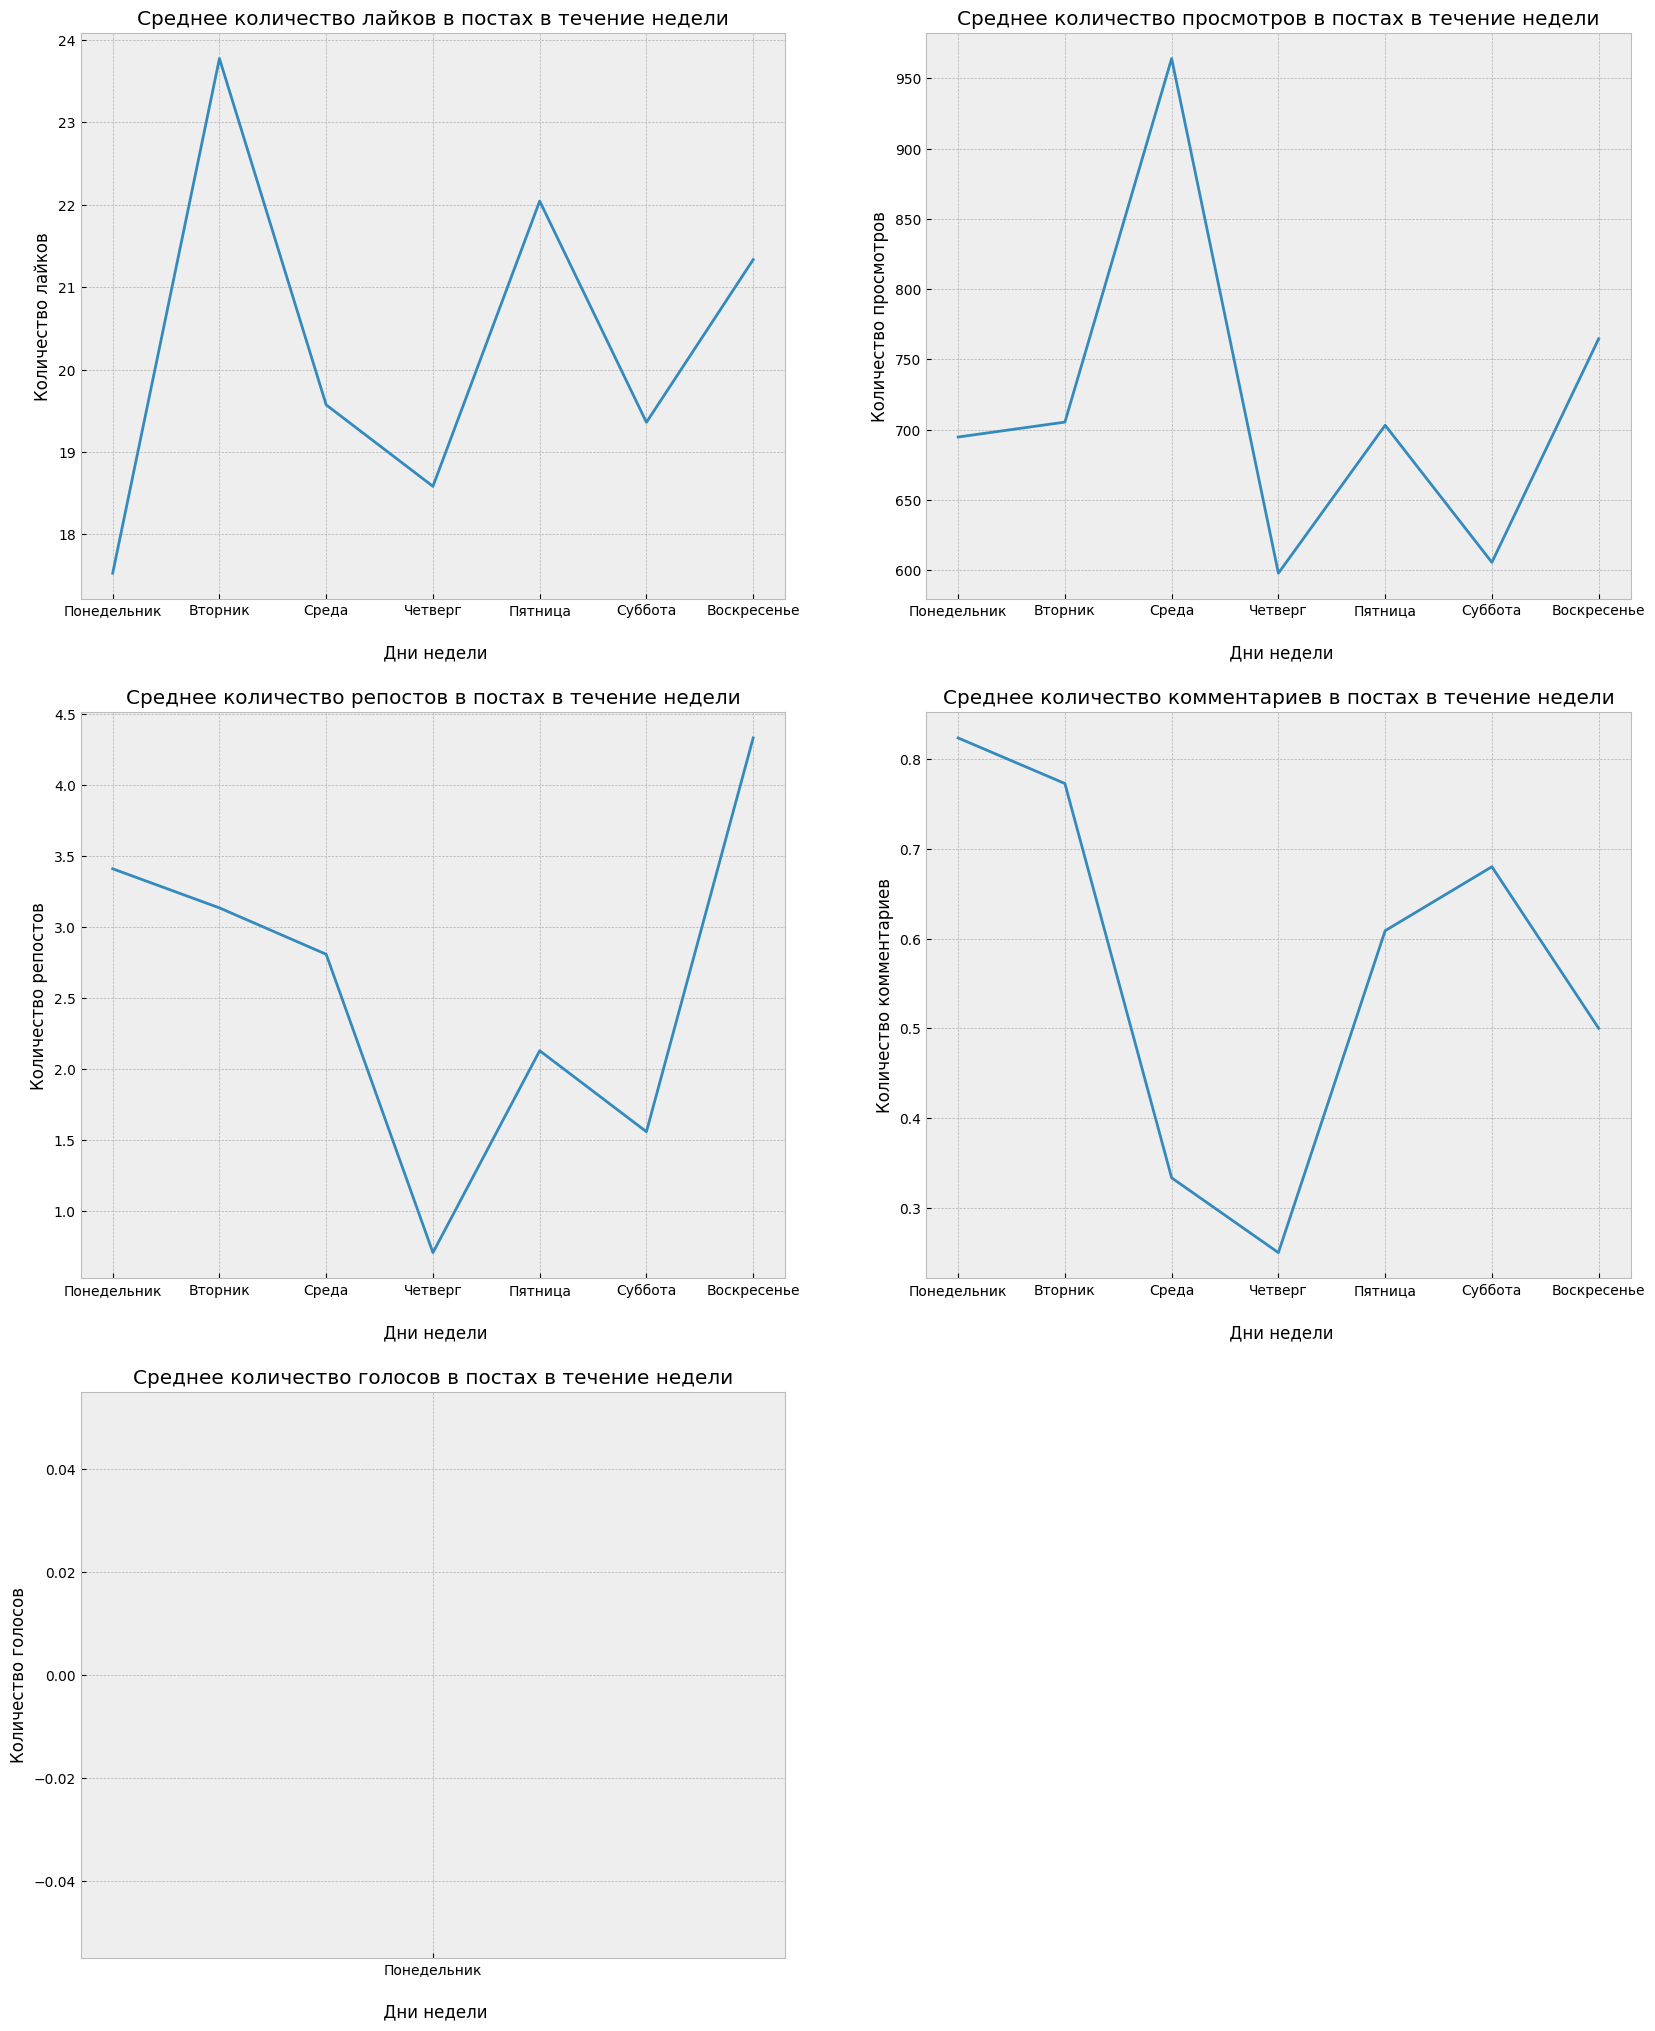

In [47]:
fig = plt.figure(figsize=(20,25))
ax = fig.add_subplot(3,2,1)
ax.plot(data_days.index, data_days.likes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество лайков')
plt.title('Среднее количество лайков в постах в течение недели')
ax = fig.add_subplot(3,2,2)
ax.plot(data_days.index, data_days.views)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество просмотров')
plt.title('Среднее количество просмотров в постах в течение недели')
ax = fig.add_subplot(3,2,3)
ax.plot(data_days.index, data_days.reposts)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество репостов')
plt.title('Среднее количество репостов в постах в течение недели')
ax = fig.add_subplot(3,2,4)
ax.plot(data_days.index, data_days.comments)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество комментариев')
plt.title('Среднее количество комментариев в постах в течение недели')
ax = fig.add_subplot(3,2,5)
ax.plot(data_days.index, data_days.votes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество голосов')
plt.title('Среднее количество голосов в постах в течение недели')
plt.show()

In [21]:
data.head()

,id,likes,views,reposts,comments,date,text,tags,votes,attachments,rubr,day_of_week
0,962,18,723,4,0,2024-10-07 21:00:00,592,[анонс],None,[video],Анонс,Понедельник
1,984,11,262,3,1,2024-10-15 23:30:00,903,[анонс],None,[photo],Анонс,Вторник
2,982,14,436,4,0,2024-10-13 00:00:02,2126,[авторское],None,[photo],Статья,Воскресенье
3,980,10,271,0,0,2024-10-12 18:31:39,359,[авторское],None,[video],Статья,Суббота
4,975,16,446,1,2,2024-10-11 22:00:00,2045,[авторское],None,[photo],Статья,Пятница


In [53]:
# Создаем DataFrame
df = pd.DataFrame(data)

# Функция для расчета ER поста
def calculate_er_post(row):
    er_post = ((row['likes'] + row['comments'] + row['reposts']) / row['views']) * 100
    return er_post

# Применяем функцию к каждой строке DataFrame
df['er_post'] = df.apply(calculate_er_post, axis=1)

# Функция для генерации ссылки на пост
def generate_post_link(row):
    return f"https://vk.com/kinocube_official?w=wall-215971748_{row['id']}"

# Добавляем новый столбец с ссылками
df['post_link'] = df.apply(generate_post_link, axis=1)

# Устанавливаем опцию для полного отображения строк
pd.set_option('display.max_colwidth', None)

# Выводим столбец с ссылками
df


,id,likes,views,reposts,comments,date,text,tags,votes,attachments,rubr,day_of_week,er_post,post_link
0,984,16,626,11,1,2024-10-15 23:30:00,903,[анонс],None,"[link, photo]",Анонс,Вторник,4.472843,https://vk.com/kinocube_official?w=wall-215971748_984
1,993,9,238,1,0,2024-10-19 22:00:00,340,"[авторское, периоды в истории кино]",None,[link],Статья,Суббота,4.201681,https://vk.com/kinocube_official?w=wall-215971748_993
2,991,9,276,1,0,2024-10-18 23:30:00,2553,[авторское],None,[photo],Статья,Пятница,3.623188,https://vk.com/kinocube_official?w=wall-215971748_991
3,990,5,268,0,0,2024-10-18 18:00:26,269,[авторское],None,[video],Видео,Пятница,1.865672,https://vk.com/kinocube_official?w=wall-215971748_990
4,989,16,335,1,0,2024-10-17 22:45:00,4882,[авторское],None,[photo],Статья,Четверг,5.074627,https://vk.com/kinocube_official?w=wall-215971748_989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,654,26,508,0,0,2024-02-29 20:00:10,386,[авторское],None,[video],Видео,Четверг,5.118110,https://vk.com/kinocube_official?w=wall-215971748_654
140,653,29,712,2,0,2024-02-29 19:00:02,5068,"[авторское, o личности]",None,[photo],Статья,Четверг,4.353933,https://vk.com/kinocube_official?w=wall-215971748_653
141,651,31,672,1,0,2024-02-28 23:00:05,335,[анонс],None,[video],Видео,Среда,4.761905,https://vk.com/kinocube_official?w=wall-215971748_651
142,649,28,754,9,0,2024-02-27 21:00:02,6001,[авторское],None,[photo],Статья,Вторник,4.907162,https://vk.com/kinocube_official?w=wall-215971748_649


In [54]:
# Сортируем DataFrame по значению ER post в порядке убывания
df = df.sort_values(by='er_post', ascending=False)

# Выбираем первые 10 постов с самыми наибольшими значениями метрики ER post
df.head(10)


,id,likes,views,reposts,comments,date,text,tags,votes,attachments,rubr,day_of_week,er_post,post_link
143,647,42,607,3,1,2024-02-27 12:00:05,534,[авторское],None,[video],Видео,Вторник,7.578254,https://vk.com/kinocube_official?w=wall-215971748_647
76,822,28,489,2,2,2024-04-24 21:02:05,249,[технокино],None,[video],Видео,Среда,6.543967,https://vk.com/kinocube_official?w=wall-215971748_822
130,682,38,677,2,0,2024-03-08 09:52:26,343,[авторское],None,[video],Видео,Пятница,5.908419,https://vk.com/kinocube_official?w=wall-215971748_682
133,674,25,451,0,1,2024-03-05 16:00:04,1694,[отчёт],None,[photo],Отчет,Вторник,5.764967,https://vk.com/kinocube_official?w=wall-215971748_674
16,959,28,522,1,0,2024-10-06 14:38:35,226,[авторское],None,[video],Видео,Воскресенье,5.555556,https://vk.com/kinocube_official?w=wall-215971748_959
118,712,36,795,8,0,2024-03-19 21:35:00,1131,[кинофестиваль],None,"[photo, doc]",Фестиваль,Вторник,5.534591,https://vk.com/kinocube_official?w=wall-215971748_712
122,701,29,564,2,0,2024-03-15 21:23:45,296,[авторское],None,[video],Видео,Пятница,5.496454,https://vk.com/kinocube_official?w=wall-215971748_701
123,700,26,510,2,0,2024-03-15 21:00:03,670,[новости],None,[photo],Новости,Пятница,5.490196,https://vk.com/kinocube_official?w=wall-215971748_700
136,661,29,604,2,2,2024-03-02 20:30:00,178,"[авторское, драйв]",None,[link],Статья,Суббота,5.463576,https://vk.com/kinocube_official?w=wall-215971748_661
137,657,27,546,2,0,2024-03-01 20:11:30,251,[авторское],None,"[video, link]",Видео,Пятница,5.311355,https://vk.com/kinocube_official?w=wall-215971748_657


In [55]:
# Удельные показатели активности пользователей. Средняя доля каждой метрики на один просмотр поста

data_days_spec = data_days.div(data_days['views'], axis=0)*100
del data_days_spec['views']
data_days_spec.reindex(weekdays)

,likes,reposts,comments,votes
day_of_week,,,,
Понедельник,2.523285,0.491109,0.118544,NaN
Вторник,3.370497,0.444674,0.109557,NaN
Среда,2.029930,0.291401,0.034573,NaN
Четверг,3.108881,0.118500,0.041824,NaN
Пятница,3.135242,0.303012,0.086575,NaN
Суббота,3.197463,0.257647,0.112308,NaN
Воскресенье,2.790191,0.566757,0.065395,NaN


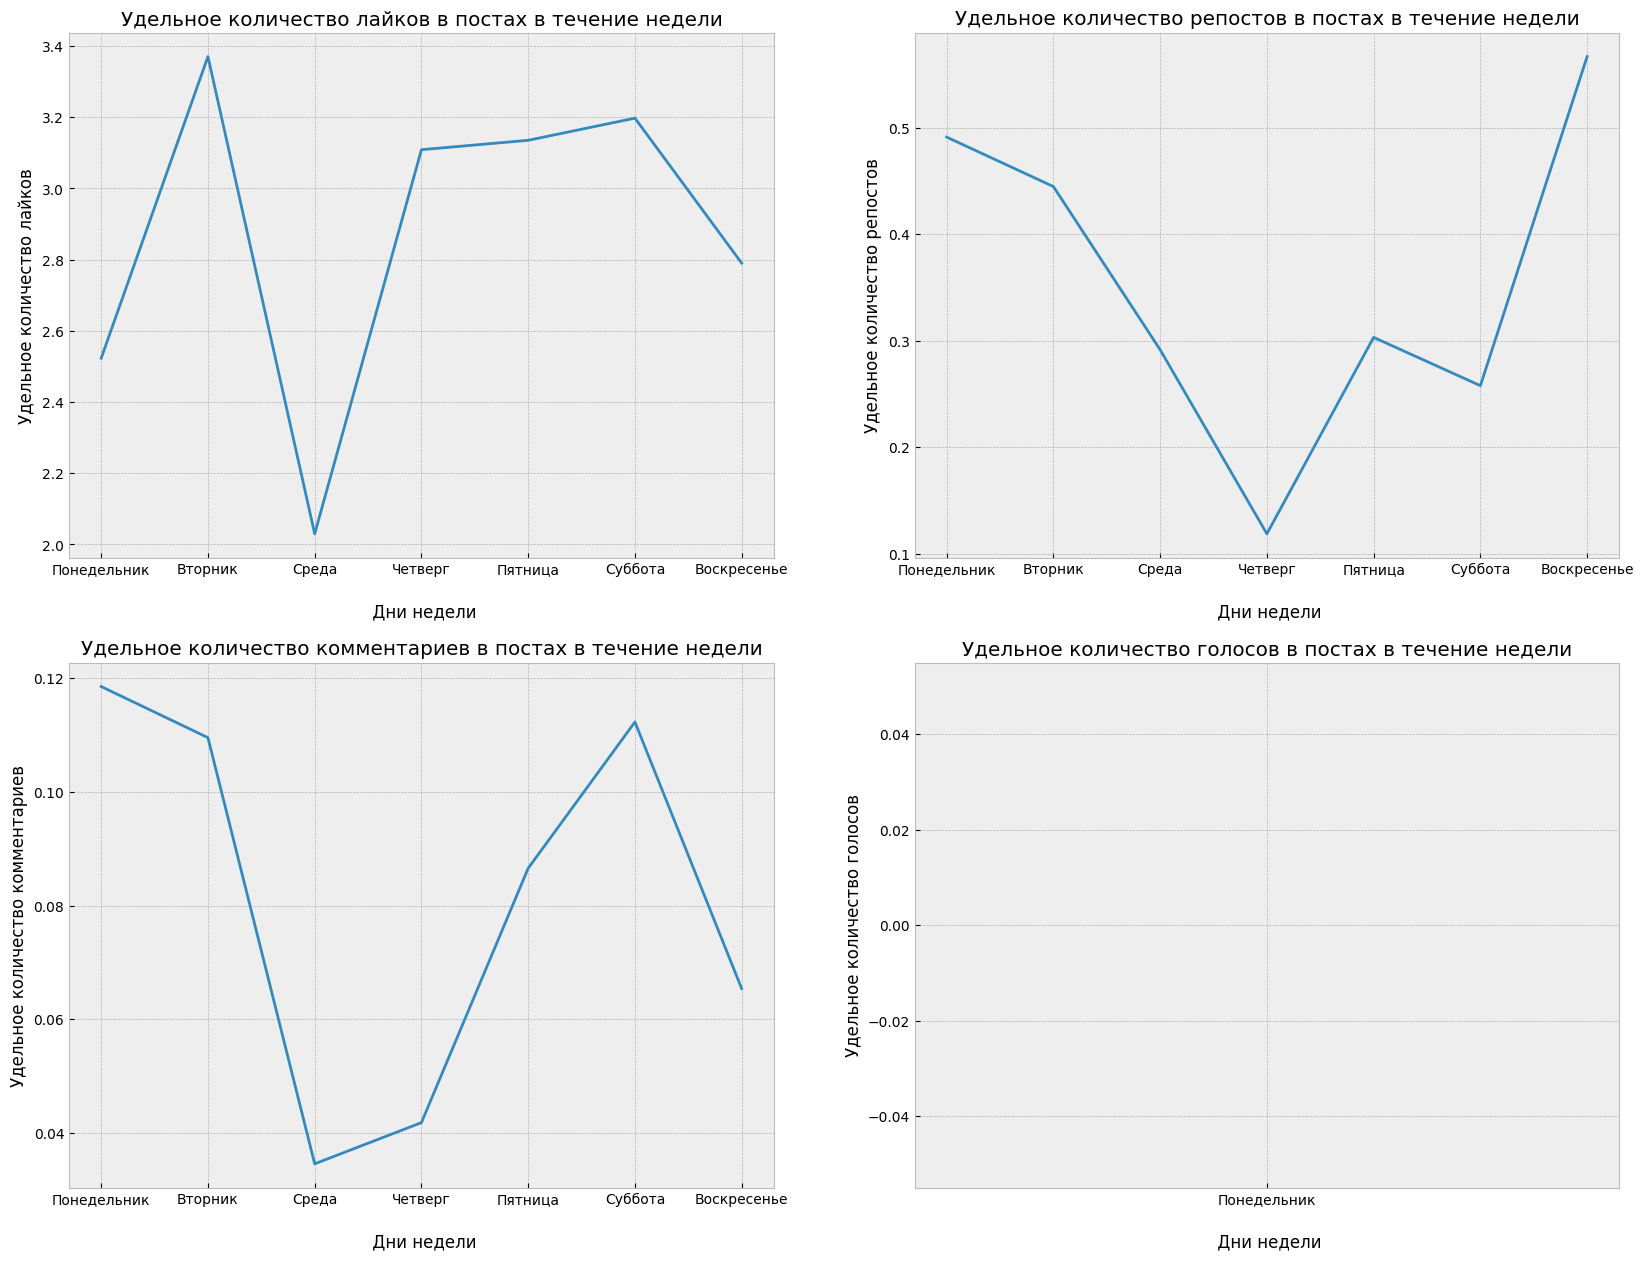

In [56]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(2,2,1)
ax.plot(data_days_spec.index, data_days_spec.likes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество лайков')
plt.title('Удельное количество лайков в постах в течение недели')
ax = fig.add_subplot(2,2,2)
ax.plot(data_days_spec.index, data_days_spec.reposts)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество репостов')
plt.title('Удельное количество репостов в постах в течение недели')
ax = fig.add_subplot(2,2,3)
ax.plot(data_days_spec.index, data_days_spec.comments)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество комментариев')
plt.title('Удельное количество комментариев в постах в течение недели')
ax = fig.add_subplot(2,2,4)
ax.plot(data_days_spec.index, data_days_spec.votes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество голосов')
plt.title('Удельное количество голосов в постах в течение недели')
plt.show()

In [57]:
# Добавляем в датасет столбец со значениями часов в момент публикаций постов

data['hour_post'] = list(map(lambda x: x.hour, data.date))

In [58]:
# Создадим датасет с будними днями
data_weekdays = data[(data['day_of_week'] == "Понедельник") |
                     (data['day_of_week'] == "Вторник") |
                     (data['day_of_week'] == "Среда") |
                     (data['day_of_week'] == "Четверг") |
                     (data['day_of_week'] == "Пятница")]


data_hours = data_weekdays[['likes', 'views', 'reposts', 'comments', 'votes', 'hour_post']]\
    .groupby('hour_post')\
    .mean()

# Удельные показатели активности пользователей. Каждая метрика в завсисмости от каждой 1000 просмотров данной публикации

data_weekdays_spec = data_hours[['likes','comments','reposts']].div(data_hours.views, axis=0)*1000
data_weekdays_spec['views'] = data_hours['views']
data_weekdays_spec

,likes,comments,reposts,views
hour_post,,,,
0,30.188679,0.000000,0.000000,530.000000
9,56.129985,0.000000,2.954210,677.000000
10,16.548463,0.000000,0.000000,423.000000
11,35.447761,0.000000,1.865672,536.000000
12,57.142857,0.985222,2.955665,507.500000
13,21.219266,0.673627,1.010441,742.250000
14,23.861171,0.723066,4.338395,922.000000
15,27.243590,0.000000,2.403846,624.000000
16,30.527290,0.308356,1.541782,648.600000


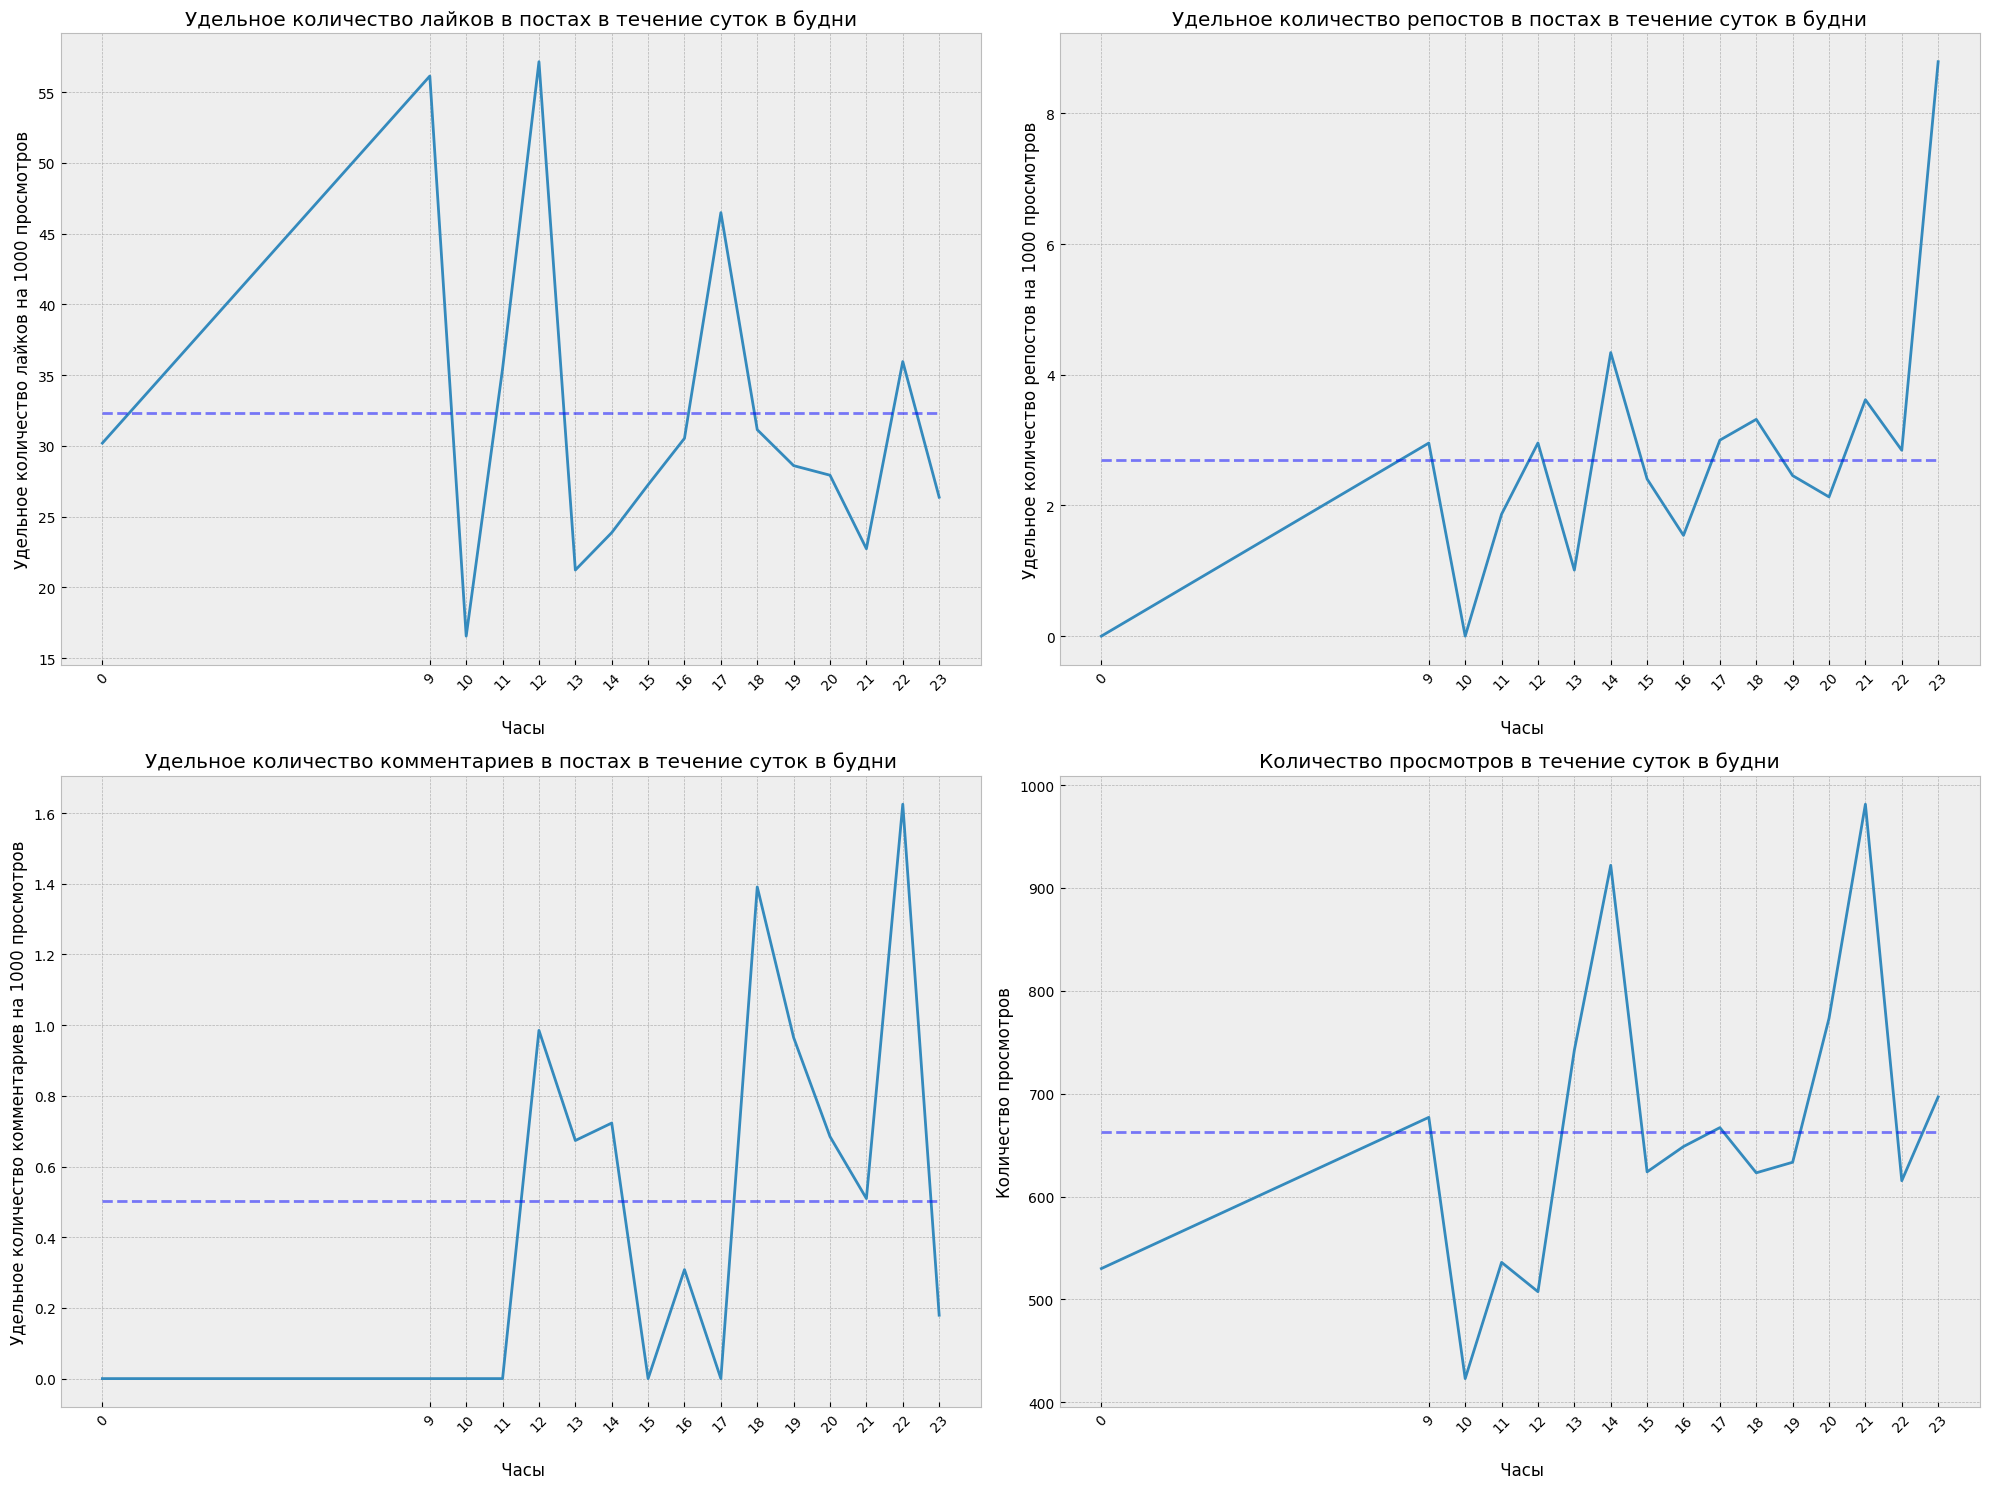

In [59]:
# Построим графики распределения удельных значений активностей пользователей в течение суток в будние дни

fig = plt.figure(figsize=(20,15))
# График 1: Удельное количество лайков на 1000 просмотров
ax = fig.add_subplot(2, 2, 1)
ax.plot(data_weekdays_spec.index, data_weekdays_spec.likes)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество лайков на 1000 просмотров')
plt.title('Удельное количество лайков в постах в течение суток в будни')
plt.hlines(data_weekdays_spec.likes.mean(), data_weekdays_spec.index.min(), data_weekdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax.set_xticks(data_weekdays_spec.index)  # Устанавливаем шаг 1 для отображения каждого часа
ax.set_xticklabels(data_weekdays_spec.index, rotation=45)  # Поворачиваем метки для лучшей читаемости

# График 2: Удельное количество репостов на 1000 просмотров
ax = fig.add_subplot(2, 2, 2)
ax.plot(data_weekdays_spec.index, data_weekdays_spec.reposts)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество репостов на 1000 просмотров')
plt.title('Удельное количество репостов в постах в течение суток в будни')
plt.hlines(data_weekdays_spec.reposts.mean(), data_weekdays_spec.index.min(), data_weekdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax.set_xticks(data_weekdays_spec.index)  # Устанавливаем шаг 1 для отображения каждого часа
ax.set_xticklabels(data_weekdays_spec.index, rotation=45)  # Поворачиваем метки для лучшей читаемости

# График 3: Удельное количество комментариев на 1000 просмотров
ax = fig.add_subplot(2, 2, 3)
ax.plot(data_weekdays_spec.index, data_weekdays_spec.comments)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество комментариев на 1000 просмотров')
plt.title('Удельное количество комментариев в постах в течение суток в будни')
plt.hlines(data_weekdays_spec.comments.mean(), data_weekdays_spec.index.min(), data_weekdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax.set_xticks(data_weekdays_spec.index)  # Устанавливаем шаг 1 для отображения каждого часа
ax.set_xticklabels(data_weekdays_spec.index, rotation=45)  # Поворачиваем метки для лучшей читаемости

# График 4: Количество просмотров
ax = fig.add_subplot(2, 2, 4)
ax.plot(data_weekdays_spec.index, data_weekdays_spec.views)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Количество просмотров')
plt.title('Количество просмотров в течение суток в будни')
plt.hlines(data_weekdays_spec.views.mean(), data_weekdays_spec.index.min(), data_weekdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax.set_xticks(data_weekdays_spec.index)  # Устанавливаем шаг 1 для отображения каждого часа
ax.set_xticklabels(data_weekdays_spec.index, rotation=45)  # Поворачиваем метки для лучшей читаемости

plt.tight_layout()  # Убираем лишние пробелы между подграфиками
plt.show()

In [60]:
data_weekend = data[(data['day_of_week'] == "Суббота") | (data['day_of_week'] == "Воскресенье")]

data_hours = data_weekend[['likes', 'views', 'reposts', 'comments', 'votes', 'hour_post']]\
    .groupby('hour_post')\
    .mean()

data_weekend_spec = data_hours[['likes','comments','reposts']].div(data_hours.views, axis=0)*1000
data_weekend_spec['views'] = data_hours['views']
data_weekend_spec

,likes,comments,reposts,views
hour_post,,,,
0,19.250253,0.000000,4.052685,493.500000
9,41.166381,0.000000,0.000000,583.000000
12,26.165168,2.044154,10.220769,1223.000000
13,25.505717,0.000000,0.000000,568.500000
14,43.349754,0.000000,0.985222,507.500000
17,40.000000,0.941176,4.235294,708.333333
18,24.541398,0.247893,2.974715,576.285714
19,27.636364,0.000000,2.909091,458.333333
20,29.789720,1.168224,1.752336,570.666667


In [61]:
data_weekend_spec.index.min()

np.int64(0)

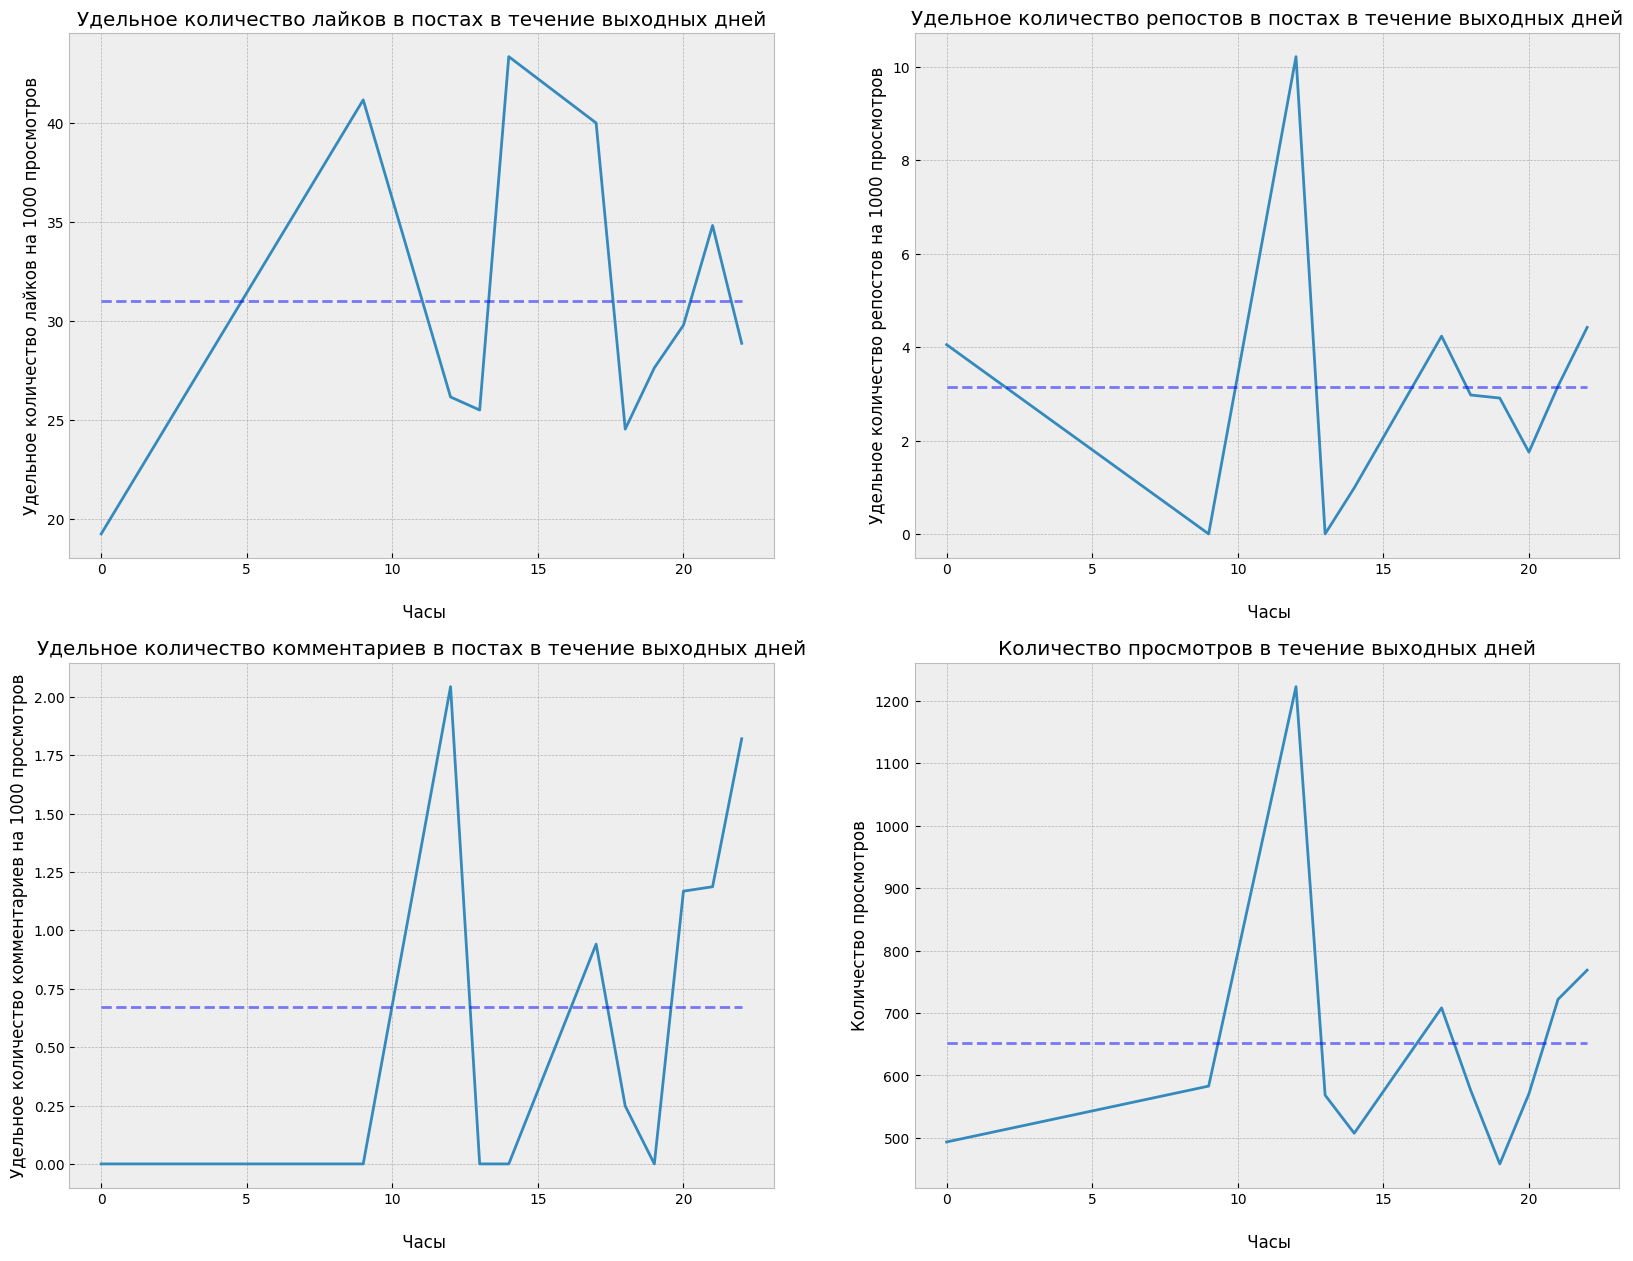

In [62]:
# Построим графики распределения удельных значений активностей пользователей в течение суток в выходные дни

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(2,2,1)
ax.plot(data_weekend_spec.index, data_weekend_spec.likes)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество лайков на 1000 просмотров')
plt.title('Удельное количество лайков в постах в течение выходных дней')
plt.hlines(data_weekend_spec.likes.mean(), data_weekend_spec.index.min(),data_weekend_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,2)
ax.plot(data_weekend_spec.index, data_weekend_spec.reposts)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество репостов на 1000 просмотров')
plt.title('Удельное количество репостов в постах в течение выходных дней')
plt.hlines(data_weekend_spec.reposts.mean(), data_weekend_spec.index.min(),data_weekend_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,3)
ax.plot(data_weekend_spec.index, data_weekend_spec.comments)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество комментариев на 1000 просмотров')
plt.title('Удельное количество комментариев в постах в течение выходных дней')
plt.hlines(data_weekend_spec.comments.mean(), data_weekend_spec.index.min(),data_weekend_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,4)
ax.plot(data_weekend_spec.index, data_weekend_spec.views)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Количество просмотров')
plt.title('Количество просмотров в течение выходных дней')
plt.hlines(data_weekend_spec.views.mean(), data_weekend_spec.index.min(),data_weekend_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
plt.show()